In [59]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [3]:
companies = [
    "NFLX", "TSLA", "ORCL", "CSCO", "CRM",  # Technology
    "QCOM", "TXN", "ADBE", "SNPS", "AMAT", "NOW", "RNG", "INTC", "HPE",  # Semiconductors & Software
    "V", "MA", "C", "JPM", "WFC", "TROW", "SCHW", "CME", "MSCI",  # Financials
    "NKE", "LULU", "TJX", "COST", "HD", "LOW", "TGT", "WMT", "BBY",  # Consumer Discretionary & Retail
    "JNJ", "PFE", "MRK", "AMGN", "ABBV", "CVS", "GSK", "AZN",  # Healthcare
    "KO", "PEP", "PG", "CLX", "CAG", "SJM", "CPB",  # Consumer Staples
    "AAPL", "MSFT", "GOOGL", "META", "AMZN",  # Technology
    "NVDA", "AMD", "IBM", "INTU", "LRCX", "MU", "ADSK", "PLTR", "ZS", "PANW", "SNOW", "DDOG", "CRWD",  # Semiconductors & Software
    "PYPL", "SQ", "SHOP", "AXP", "GS", "MS", "SPGI", "BLK", "BAC",  # Financials
    "F", "GM", "DE", "RCL", "UAL", "DAL", "AAL", "BKNG", "MAR", "HLT",  # Consumer Discretionary & Travel
    "ABBV", "ABT", "BMY", "LLY", "GILD", "MRNA", "REGN", "TMO", "ISRG", "SYK", "BDX", "DHR",  # Healthcare
    "DIS", "EA", "MO", "CL", "EL", "KHC",  # Consumer Staples & Entertainment
]


In [32]:
data = pd.DataFrame()

In [ ]:
for i in companies:
    try:

        curr = yf.download(i, start='2014-10-15', end='2024-10-26')

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

In [6]:
def calculate_tech_ind(curr, data):

    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Exponential Moving Average
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index

    # Bollinger Bands: Measures volatility with a moving average and standard deviations
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line: Trend-following momentum indicator
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume: Volume-based trend indicator
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX (Average Directional Index): Measures trend strength
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator: Identifies trend direction and strength
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values
    
    uncleaned_data = pd.concat([curr, data], axis = 0)

    uncleaned_data = uncleaned_data.iloc[14:, :]

    uncleaned_data.fillna(method='ffill', inplace=True)

    uncleaned_data.fillna(method='bfill', inplace=True)

    #scaled_data = scale_data(uncleaned_data)

    #result_df = final_pcas(scaled_data)

    return uncleaned_data

In [7]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [34]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low']
       technical_indicators = ['SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']
       volume_column = 'Volume'
       
       for col in price_columns:
              uncscaled_data = remove_outliers(uncscaled_data, col)
       uncscaled_data = remove_outliers(uncscaled_data, 'Close')
       
       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()

       uncscaled_data[price_columns] = min_max_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = min_max_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [45]:
scaled_data = scale_data(data)

In [47]:
scaled_data.shape

(421844, 17)

In [48]:
target_reg = scaled_data['Close']
target_classification = (scaled_data['Close'].shift(-1) > scaled_data['Close']).astype(int)

In [49]:
input = scaled_data.drop(columns=['Close', 'Adj Close'])

In [50]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(input, target_reg, test_size=0.2, random_state=42)

In [52]:
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(input, target_classification, test_size=0.2, random_state=42)

In [53]:
print(X_train_reg.shape, y_train_reg.shape)
print(X_train_cal.shape, y_train_cal.shape)

(337475, 15) (337475,)
(337475, 15) (337475,)


In [71]:
def final_pcas(data):
       feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']

       X = data[feature_columns]

       pca = PCA(n_components=8)  
       X_pca = pca.fit_transform(X)

       explained_variance = pca.explained_variance_ratio_
       cumulative_variance = np.cumsum(explained_variance)


       n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
       pca_final = PCA(n_components=n_components_to_keep)
       X_final = pca_final.fit_transform(X)

       pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
       pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
       data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal'])                                   #Cost was removed from here
       result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

       return result_df


In [ ]:
#data = final_pcas(data)

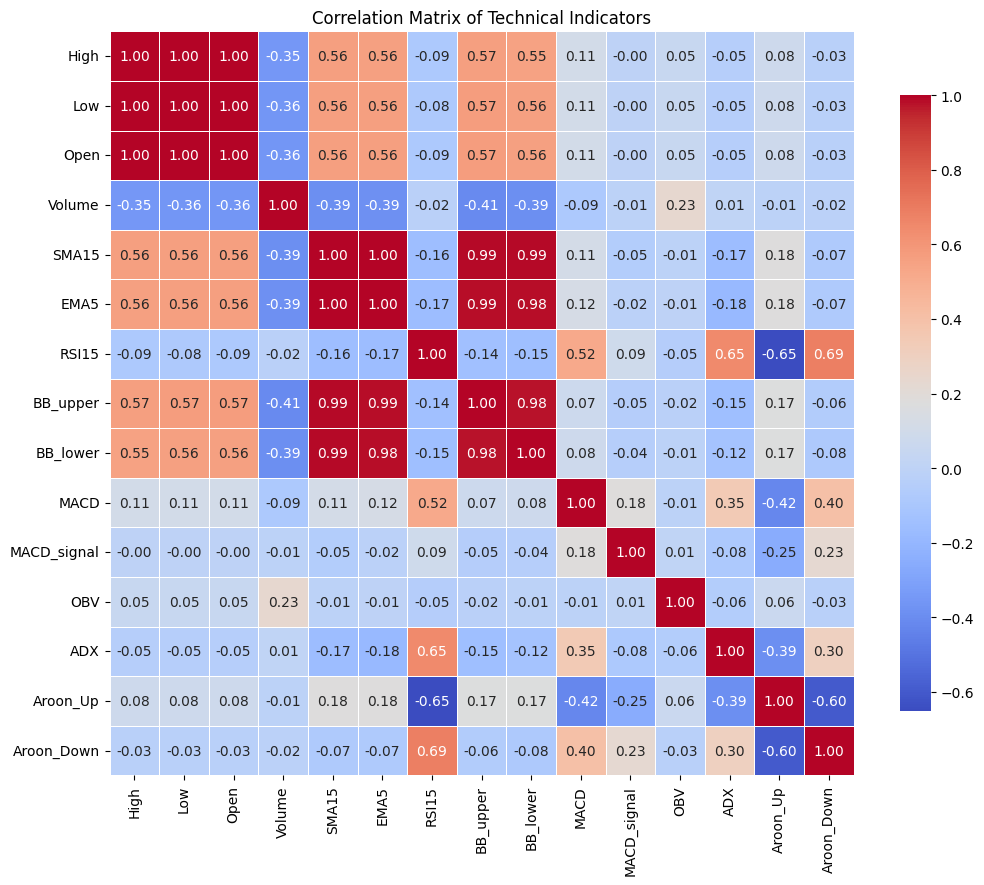

In [54]:
correlation_matrix = input.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


-----------
Regressor
----------

In [55]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_reg, y_train_reg)

# Get feature importance scores
feature_importance = xgb_model.feature_importances_
important_features = X_train_reg.columns[feature_importance > 0.01]
print(feature_importance, important_features)

[5.5583584e-01 4.4372940e-01 9.1724534e-05 2.3955752e-05 1.2860279e-05
 3.2759617e-05 1.6755836e-05 5.8166374e-06 3.0300780e-05 1.3029408e-05
 1.1370876e-05 1.4503484e-04 1.5134501e-05 2.4936562e-05 1.1127957e-05] Index(['High', 'Low'], dtype='object')


In [56]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred = model.predict(X_test_reg)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
r2 = r2_score(y_test_reg, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error (MSE): 0.9886341756996765
Root Mean Squared Error (RMSE): 0.9943008476812621
R² Score: 0.9998489803371347


In [62]:
kf = KFold(n_splits=100, shuffle=True, random_state=42)
mse_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_train_reg):
    X_train, X_val = X_train_reg.iloc[train_index], X_train_reg.iloc[test_index]
    y_train, y_val = y_train_reg.iloc[train_index], y_train_reg.iloc[test_index]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)


# Print average scores
print(f'Average MSE: {np.mean(mse_scores)}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Average R² Score: {np.mean(r2_scores)}')

Average MSE: 0.9704381270544457
Average RMSE: 0.9826717410438492
Average R² Score: 0.9998514551816342


In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # for regression
                           cv=5,
                           verbose=1)

grid_search.fit(X_train_reg, y_train_reg)
print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Mean Squared Error (MSE): 0.9709060952245
Root Mean Squared Error (RMSE): 0.9853456729617784


-----------
Classifier
-----------

In [65]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train_cal, y_train_cal)
y_pred = model.predict(X_test_cal)

accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7392881271557088


In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, val_index in kf.split(X_train_cal):
    X_train, X_val = X_train_cal.iloc[train_index], X_train_cal.iloc[val_index]
    y_train, y_val = y_train_cal.iloc[train_index], y_train_cal.iloc[val_index]

    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

print(f'Average Accuracy: {np.mean(accuracy_scores)}')

Average Accuracy: 0.737645751537151


In [66]:
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train_cal, y_train_cal)
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


In [67]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_cal)
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7391221894297668


-------
Deep Learning - Regressor
-------

In [69]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)), 
    layers.Dense(32, activation='relu'), 
    layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_reg, y_train_reg, epochs=100, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

results = pd.DataFrame({
    'Actual': y_test_reg,
    'Predicted': y_pred.flatten()  
})

print(results.head())


Epoch 1/100


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8437/8437 [==============================] - 22s 2ms/step - loss: 464.1309 - val_loss: 2.0769
Epoch 2/100
8437/8437 [==============================] - 21s 2ms/step - loss: 2.3301 - val_loss: 2.4744
Epoch 3/100
8437/8437 [==============================] - 21s 2ms/step - loss: 2.1506 - val_loss: 1.9585
Epoch 4/100
8437/8437 [==============================] - 20s 2ms/step - loss: 2.0398 - val_loss: 1.7534
Epoch 5/100
8437/8437 [==============================] - 20s 2ms/step - loss: 1.9199 - val_loss: 1.6604
Epoch 6/100
8437/8437 [==============================] - 20s 2ms/step - loss: 1.7964 - val_loss: 1.6185
Epoch 7/100
8437/8437 [==============================] - 20s 2ms/step - loss: 1.7097 - val_loss: 1.7728
Epoch 8/100
8437/8437 [==============================] - 20s 2ms/step - loss: 1.6274 - val_loss: 1.5462
Epoch 9/100
8437/8437 [==============================] - 20s 2ms/step - loss: 1.5689 - val_loss: 4.2475
Epoch 10/100
8437/8437 [==============================] - 20s 2ms/step - l

-----
Deep Learning - Classification
-----

In [70]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_cal.shape[1],)), 
    layers.Dense(32, activation='relu'), 
    layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_cal, y_train_cal, epochs=100, batch_size=32, validation_split=0.2)

y_pred = (model.predict(X_test_cal) > 0.5).astype("int32")
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

Epoch 1/100


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8437/8437 [==============================] - 30s 4ms/step - loss: 0.1479 - val_loss: 0.1427
Epoch 2/100
8437/8437 [==============================] - 30s 4ms/step - loss: 0.1416 - val_loss: 0.1397
Epoch 3/100
8437/8437 [==============================] - 30s 4ms/step - loss: 0.1398 - val_loss: 0.1408
Epoch 4/100
8437/8437 [==============================] - 27s 3ms/step - loss: 0.1390 - val_loss: 0.1382
Epoch 5/100
8437/8437 [==============================] - 26s 3ms/step - loss: 0.1384 - val_loss: 0.1379
Epoch 6/100
8437/8437 [==============================] - 23s 3ms/step - loss: 0.1380 - val_loss: 0.1383
Epoch 7/100
8437/8437 [==============================] - 27s 3ms/step - loss: 0.1378 - val_loss: 0.1383
Epoch 8/100
8437/8437 [==============================] - 27s 3ms/step - loss: 0.1377 - val_loss: 0.1380
Epoch 9/100
8437/8437 [==============================] - 29s 3ms/step - loss: 0.1375 - val_loss: 0.1377
Epoch 10/100
8437/8437 [==============================] - 26s 3ms/step - los

In [76]:
X_train_cal_pca = final_pcas(X_train_cal)
X_test_cal_pca = final_pcas(X_test_cal)

In [79]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_cal_pca.shape[1],)), 
    layers.Dense(32, activation='relu'), 
    layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_cal_pca, y_train_cal, epochs=100, batch_size=32, validation_split=0.2)

y_pred = (model.predict(X_test_cal_pca) > 0.5).astype("int32")
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

Epoch 1/100


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
8437/8437 [==============================] - 21s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 4/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 6/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 8/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 9/100
8437/8437 [==============================] - 21s 3ms/step - loss: nan - val_loss: nan
Epoch 10/100
8437/8437 [==============================] - 21s 2ms/step - loss: nan - val_loss: nan
Epoch 11/100
8437/8437 [=======

In [77]:
from keras import layers, models
from keras_tuner import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                           activation='relu', input_shape=(X_train_cal.shape[1],)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=16, max_value=48, step=16),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=1,
                     directory='my_dir',
                     project_name='helloworld')

tuner.search(X_train_cal, y_train_cal, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 02m 20s]
val_accuracy: 0.735521137714386

Best val_accuracy So Far: 0.7374324202537537
Total elapsed time: 00h 23m 44s


In [80]:
from keras import layers, models
from keras_tuner import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                           activation='relu', input_shape=(X_train_cal_pca.shape[1],)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=16, max_value=48, step=16),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=1,
                     directory='my_dir_pca',
                     project_name='helloworld')

tuner.search(X_train_cal_pca, y_train_cal, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 02m 43s]
val_accuracy: 0.719045877456665

Best val_accuracy So Far: 0.719045877456665
Total elapsed time: 00h 27m 21s


In [ ]:
import pandas as pd

def calculate_atr(data, window=14):
    # Calculate the True Range
    X_train_cal['H-L'] = X_train_cal['High'] - X_train_cal['Low']
    X_train_cal['H-PC'] = abs(X_train_cal['High'] - X_train_cal['Close'].shift(1))
    X_train_cal['L-PC'] = abs(X_train_cal['Low'] - X_train_cal['Close'].shift(1))
    
    true_range = X_train_cal[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

# Example usage
X_train_cal['ATR'] = calculate_atr(X_train_cal)


In [83]:
data['ATR']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
496977    0.490002
496978    0.490002
496979    0.490002
496980    0.490002
496981    0.490002
Name: ATR, Length: 496982, dtype: float64

In [82]:
def calculate_roc(data, window=14):
    roc = (data['Close'].diff(window) / data['Close'].shift(window)) * 100
    return roc

# Example usage
data['ROC'] = calculate_roc(data)
